In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
first_df = pd.read_csv('Data/RFP/2025_04_24.csv')
second_df = pd.read_csv('Data/RFP/2025_04_24_secondmeasurement.csv')
third_df = pd.read_csv('Data/RFP/2025_04_24_thirdmeasurement.csv')

In [3]:
first_df['Rep'] = 1
second_df['Rep'] = 2
third_df['Rep'] = 3

df = pd.concat([first_df, second_df, third_df], ignore_index=True)
df = df.sort_values(by=['EC#'], ignore_index=True)
df.head(10)

,EC#,Strain,Sequence_infill,Sequence,Avg_OD600,Avg_GFP,Avg_RFP,Rel_RFP,Rep
0,33,pClone_GFP,CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT,AATACTAGAGGTCTTCCGACTCCGGGCGCTATCATGCCATACCGCG...,0.178331,5.155400e+05,5791.166670,32474,1
1,33,pClone_GFP,CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT,AATACTAGAGGTCTTCCGACTCCGGGCGCTATCATGCCATACCGCG...,0.340217,5.909457e+05,7450.333333,21899,2
2,34,P533A,TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA,AATACTAGAGGTCTTCCGACTTAACAATTAATCATCCGGCTCGTAA...,0.295065,7.084137e+05,138717.833300,470127,2
3,34,P533A,TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA,AATACTAGAGGTCTTCCGACTTAACAATTAATCATCCGGCTCGTAA...,0.091953,4.463880e+05,64155.166700,697698,1
4,35,P5,TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA,AATACTAGAGGTCTTCCGACTTGACAATTAATCATCCGGCTCGTAA...,0.163669,1.391900e+05,353329.667000,2158810,1
5,35,P5,TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA,AATACTAGAGGTCTTCCGACTTGACAATTAATCATCCGGCTCGTAA...,0.362198,2.659952e+05,349778.333300,965711,2
6,36,OsmY,CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACAAA,ATACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATCTA...,0.069388,1.902548e+06,126919.167000,1829128,1
7,36,OsmY,CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACAAA,ATACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATCTA...,0.264411,4.508661e+06,245599.833300,928857,2
8,37,OsmY_C12A,CCCGAGCGGTTTCAAAATTGTGATATATATTTAACAAA,TACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATATAT...,0.277999,4.889728e+06,459233.333300,1651925,2
9,37,OsmY_C12A,CCCGAGCGGTTTCAAAATTGTGATATATATTTAACAAA,TACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATATAT...,0.084288,2.120625e+06,221796.167000,2631408,1


In [4]:
unique_promoters = df.sort_values(by=['Strain'])['Strain'].unique()

color_map = {
    'pClone_GFP' : 'blue',
    'Lac' : 'blue',
    'OsmY' : 'blue',
    'OsmY_C12A' : 'blue',
    'P5' : 'blue',
    'P533A' : 'blue',

    'high_dG (low_expr)' : 'red',
    'low_dG (high_expr)' : 'red',
    'med_dG (med_expr)' : 'red',

    'p125' : 'green',
    'p250' : 'green',
    'p375' : 'green',
    'p500' : 'green',
    'p600' : 'green',
    'p625' : 'green',
    'p650' : 'green',
    'p750' : 'green', 
    'p800' : 'green',
    'p875' : 'green',

    'p1000 (del_22A)' : 'orange',
    'p1000 (del_23T)' : 'orange',
    'p700 (del_21C)' : 'orange',
    'p750 (del_19T)' : 'orange',
    'p750 (del_22A)' : 'orange', 
}


### Based on Urtecho's formatting
---

In [5]:
# Urtecho does 120 bp upstream and 30 bp downstream of the TSS.
# We take 100 bp upstream of the first BsaI cut site, to account for the length of the insert
# Becasue the TSS starts 1 nucleotide before the second BsaI cut site, we take 29 nucleotides downstream of the cut site

upstream = 'TCACCATCTAATTCAACAAGAATTGGGACAACTCCAGTGAAAAGTTCTTCTCCTTTACGCATCTAGTATTTCTCCTCTTTAATACTAGAGGTCTTCCGAC' # length 100
downstream = 'GCGGGAAGACAACTAGGGGCCCAAGTTCA' # length 29

for idx, row in df.iterrows():
    infill = row['Sequence_infill']
    infill.replace('_', '')
    infill += downstream
    upstream_to_add = upstream[len(upstream) - (150 - len(infill)):]
    sequence = upstream_to_add + infill

    df.at[idx, 'Sequence'] = sequence

In [6]:
CNN_5_0 = keras.saving.load_model('Models/CNN_5_0.keras')
CNN_5_1 = keras.saving.load_model('Models/CNN_5_1.keras')
CNN_5_6 = keras.saving.load_model('Models/CNN_5_6.keras')
CNN_6_1_2 = keras.saving.load_model('Models/CNN_6_1_2.keras')

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = []
    sequence
    for nucleotide in sequence:
        encoding += [mapping[nucleotide]]
    return encoding

sequences = df['Sequence'].apply(lambda x: x.replace('_', '')).tolist()
df['CNN_5_0_Pred_RFP'] = CNN_5_0.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences])).flatten()
df['CNN_5_1_Pred_RFP'] = CNN_5_1.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences])).flatten()
df['CNN_5_6_Pred_RFP'] = CNN_5_6.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences])).flatten()
df['CNN_6_1_2_Pred_RFP'] = CNN_6_1_2.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences])).flatten()
df.head()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000280BC5AAE80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


,EC#,Strain,Sequence_infill,Sequence,Avg_OD600,Avg_GFP,Avg_RFP,Rel_RFP,Rep,CNN_5_0_Pred_RFP,CNN_5_1_Pred_RFP,CNN_5_6_Pred_RFP,CNN_6_1_2_Pred_RFP
0,33,pClone_GFP,CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT,ACAAGAATTGGGACAACTCCAGTGAAAAGTTCTTCTCCTTTACGCA...,0.178331,515540.0000,5791.166670,32474,1,0.555771,0.292036,-0.095840,0.188363
1,33,pClone_GFP,CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT,ACAAGAATTGGGACAACTCCAGTGAAAAGTTCTTCTCCTTTACGCA...,0.340217,590945.6667,7450.333333,21899,2,0.555771,0.292036,-0.095840,0.188363
2,34,P533A,TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA,ACAAGAATTGGGACAACTCCAGTGAAAAGTTCTTCTCCTTTACGCA...,0.295065,708413.6667,138717.833300,470127,2,0.603093,0.290035,-0.088851,0.245347
3,34,P533A,TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA,ACAAGAATTGGGACAACTCCAGTGAAAAGTTCTTCTCCTTTACGCA...,0.091953,446388.0000,64155.166700,697698,1,0.603093,0.290035,-0.088851,0.245347
4,35,P5,TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA,ACAAGAATTGGGACAACTCCAGTGAAAAGTTCTTCTCCTTTACGCA...,0.163669,139190.0000,353329.667000,2158810,1,0.639651,0.286704,0.194116,0.312501


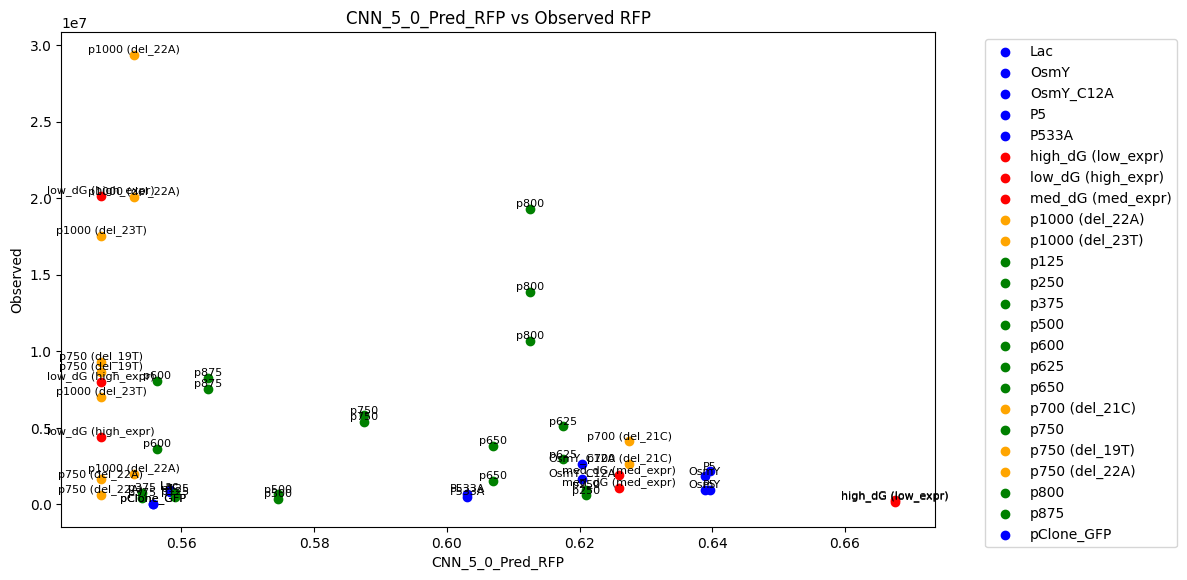

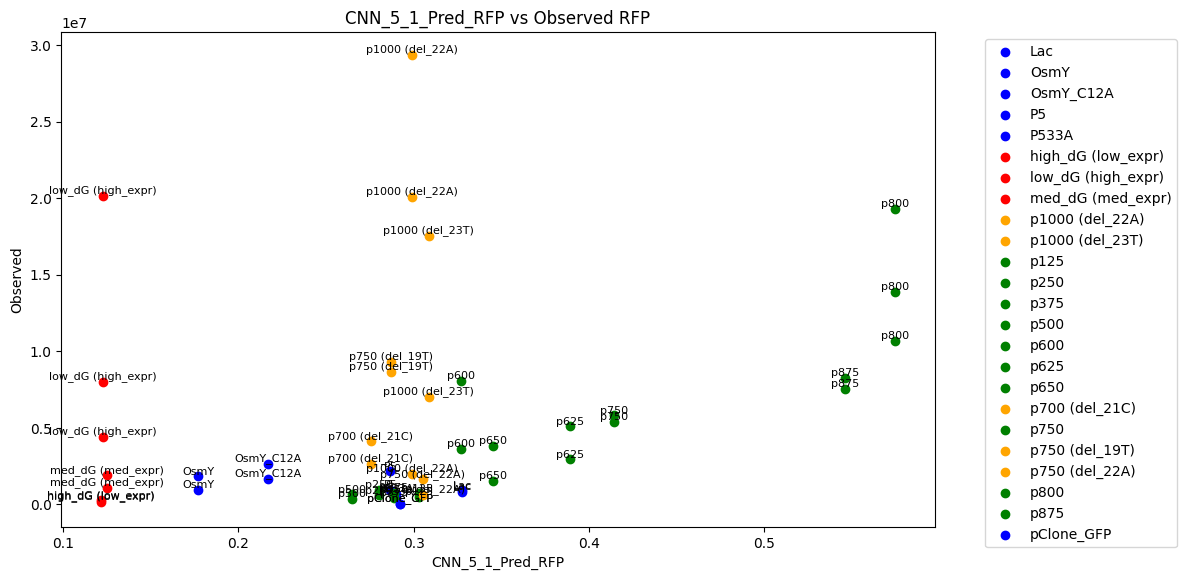

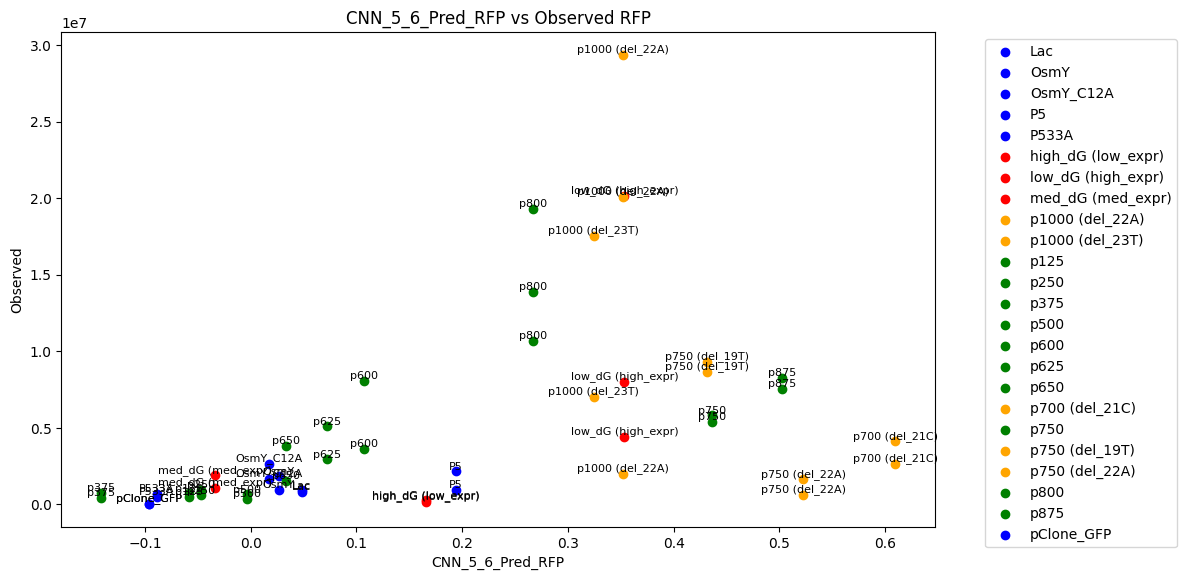

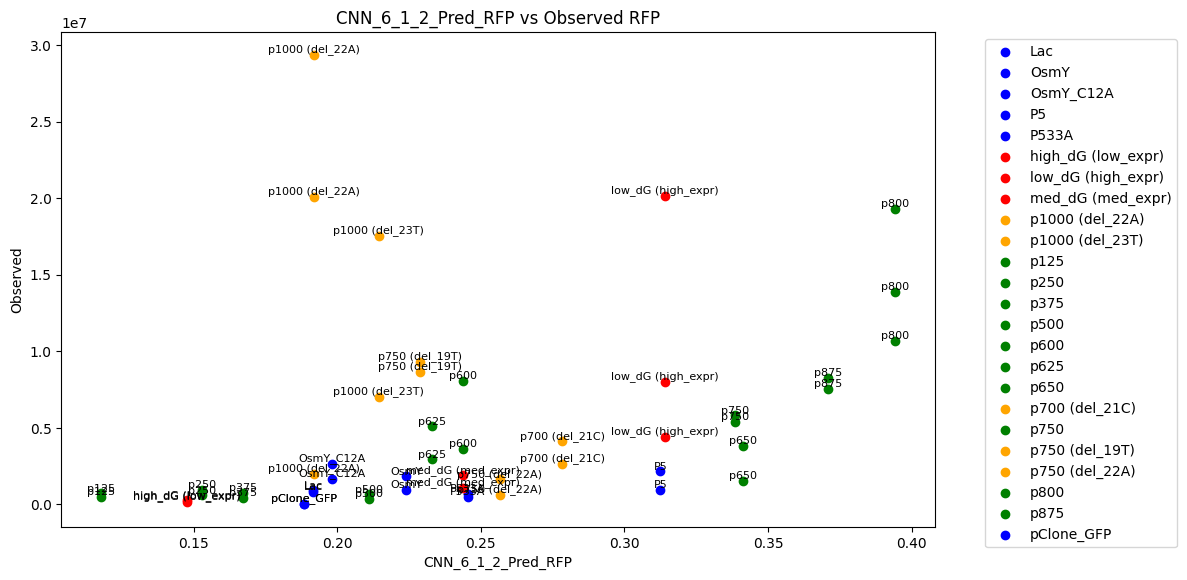

In [7]:
for predictions in ['CNN_5_0_Pred_RFP', 'CNN_5_1_Pred_RFP', 'CNN_5_6_Pred_RFP', 'CNN_6_1_2_Pred_RFP']:
    plt.figure(figsize=(12, 6))

    for promoter in unique_promoters:
        subset = df[df['Strain'] == promoter]
        color = color_map[promoter]
        plt.scatter(subset[predictions], subset['Rel_RFP'], c=[color], label=promoter)

    plt.xlabel(predictions)
    plt.ylabel('Observed')
    plt.title(f'{predictions} vs Observed RFP')

    for row in df.iterrows():
        plt.text(row[1][predictions], row[1]['Rel_RFP'], row[1]['Strain'], fontsize=8, ha='center', va='bottom')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### Based on LaFleur's Formatting
---

In [8]:
upstream = 'TCTCCTTTACGCATCTAGTATTTCTCCTCTTTAATACTAGAGGTCTTCCGAC' # length 100
downstream = 'GCGGGAAGACAACTAGGGGC' # length 20

len(upstream)

52

In [9]:
# LaFluer is mostly 52 bp upstream and 21 bp downstream of the TSS.
# We take 52 bp upstream of the first BsaI cut site, and account for the length of the insert
# Becasue the TSS starts 1 nucleotide before the second BsaI cut site, we take 20 nucleotides downstream of the cut site

upstream = 'TCTCCTTTACGCATCTAGTATTTCTCCTCTTTAATACTAGAGGTCTTCCGAC' # length 52
downstream = 'GCGGGAAGACAACTAGGGGC' # length 20

for idx, row in df.iterrows():
    infill = row['Sequence_infill']
    infill.replace('_', '')
    infill += downstream
    upstream_to_add = upstream[len(upstream) - (73 - len(infill)):]
    sequence = upstream_to_add + infill
    df.at[idx, 'Sequence'] = sequence

In [10]:
CNN_5_0 = keras.saving.load_model('Models/CNN_5_0.keras')
CNN_5_1 = keras.saving.load_model('Models/CNN_5_1.keras')
CNN_5_6 = keras.saving.load_model('Models/CNN_5_6.keras')
CNN_6_1_2 = keras.saving.load_model('Models/CNN_6_1_2.keras')

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = []
    sequence
    for nucleotide in sequence:
        encoding += [mapping[nucleotide]]
    return encoding

sequences = df['Sequence'].apply(lambda x: x.replace('_', '')).tolist()
df['CNN_5_0_Pred_RFP'] = CNN_5_0.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences])).flatten()
df['CNN_5_1_Pred_RFP'] = CNN_5_1.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences])).flatten()
df['CNN_5_6_Pred_RFP'] = CNN_5_6.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences])).flatten()
df['CNN_6_1_2_Pred_RFP'] = CNN_6_1_2.predict(np.array([padded_one_hot_encode(seq.zfill(150)) for seq in sequences])).flatten()
df.head()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


,EC#,Strain,Sequence_infill,Sequence,Avg_OD600,Avg_GFP,Avg_RFP,Rel_RFP,Rep,CNN_5_0_Pred_RFP,CNN_5_1_Pred_RFP,CNN_5_6_Pred_RFP,CNN_6_1_2_Pred_RFP
0,33,pClone_GFP,CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT,ACTAGAGGTCTTCCGACCGATGGTGTCAACGTAAATGCATGCCGCT...,0.178331,515540.0000,5791.166670,32474,1,0.724750,0.312859,0.397491,0.259964
1,33,pClone_GFP,CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT,ACTAGAGGTCTTCCGACCGATGGTGTCAACGTAAATGCATGCCGCT...,0.340217,590945.6667,7450.333333,21899,2,0.724750,0.312859,0.397491,0.259964
2,34,P533A,TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA,ACTAGAGGTCTTCCGACTTAACAATTAATCATCCGGCTCGTAATTT...,0.295065,708413.6667,138717.833300,470127,2,0.683255,0.365096,0.405392,0.421601
3,34,P533A,TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA,ACTAGAGGTCTTCCGACTTAACAATTAATCATCCGGCTCGTAATTT...,0.091953,446388.0000,64155.166700,697698,1,0.683255,0.365096,0.405392,0.421601
4,35,P5,TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA,ACTAGAGGTCTTCCGACTTGACAATTAATCATCCGGCTCGTAATTT...,0.163669,139190.0000,353329.667000,2158810,1,0.703018,0.459430,0.471449,0.440624


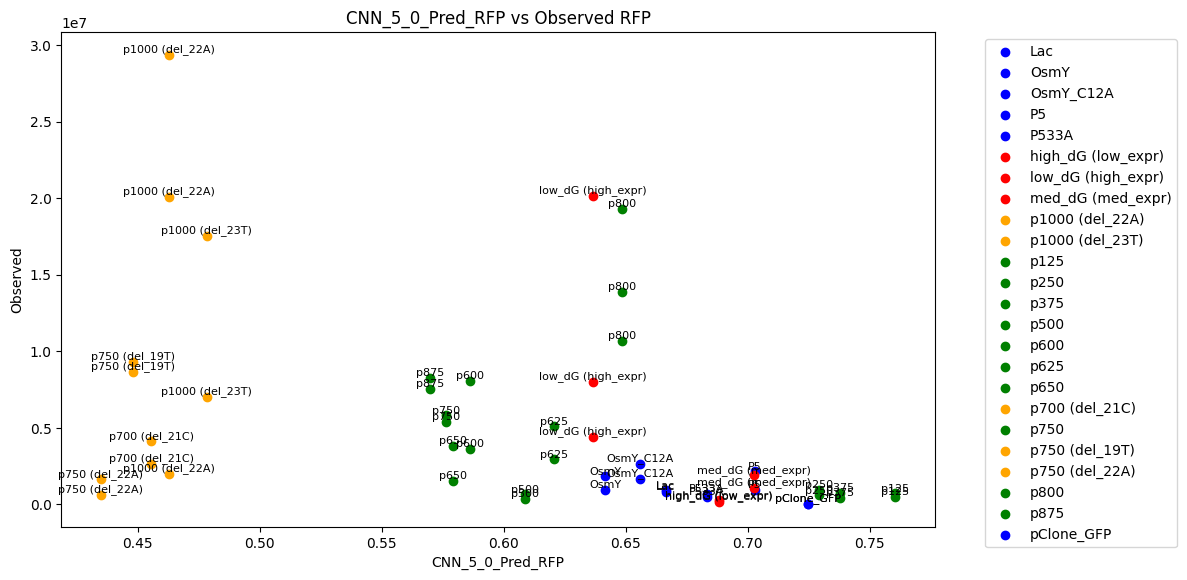

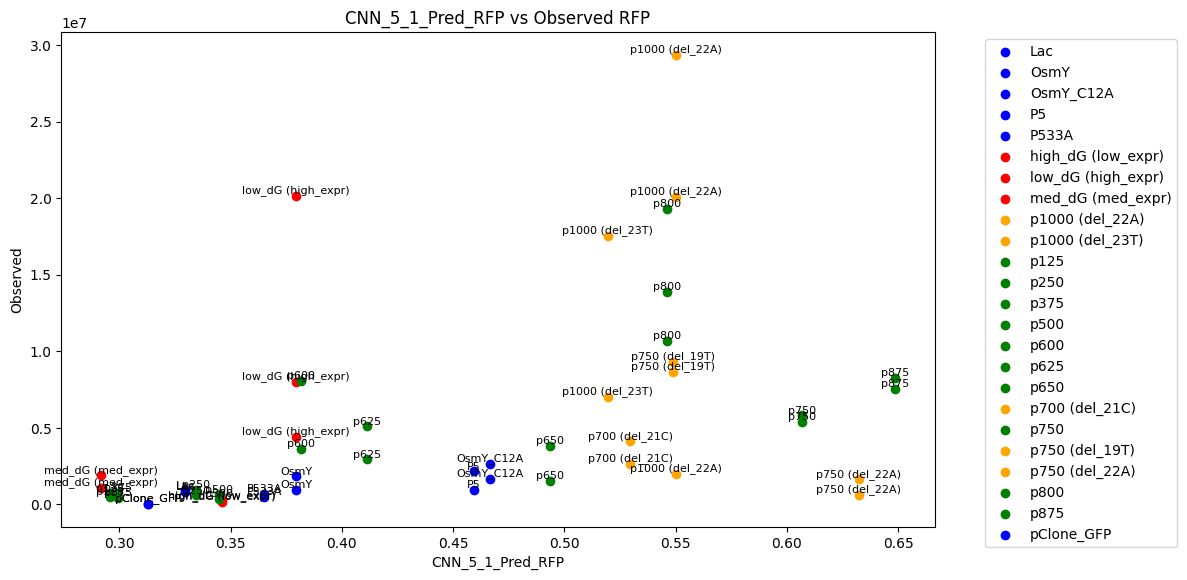

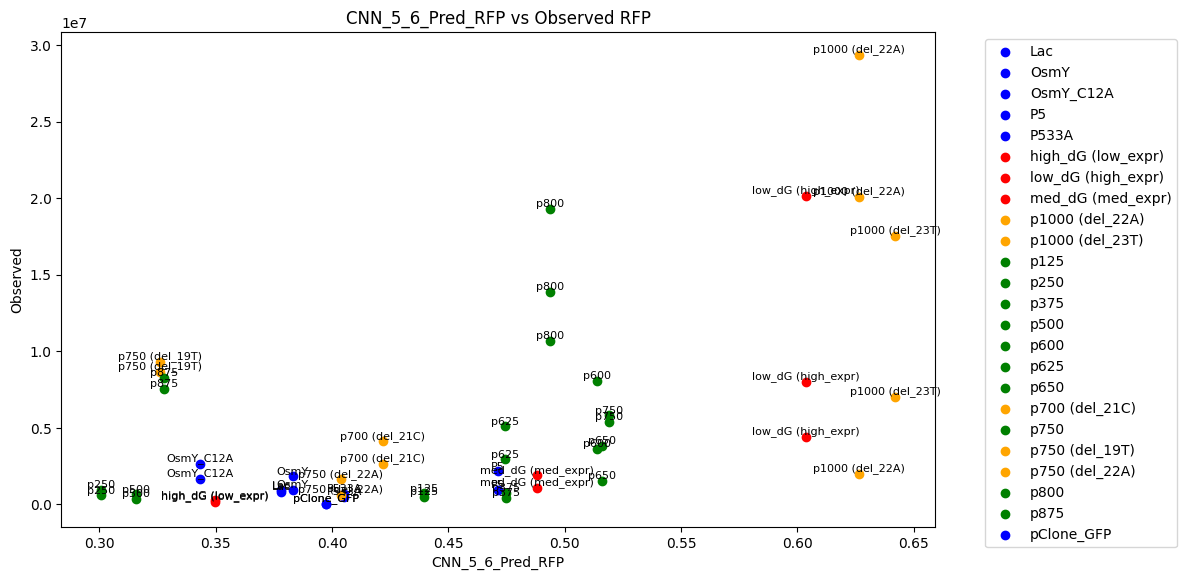

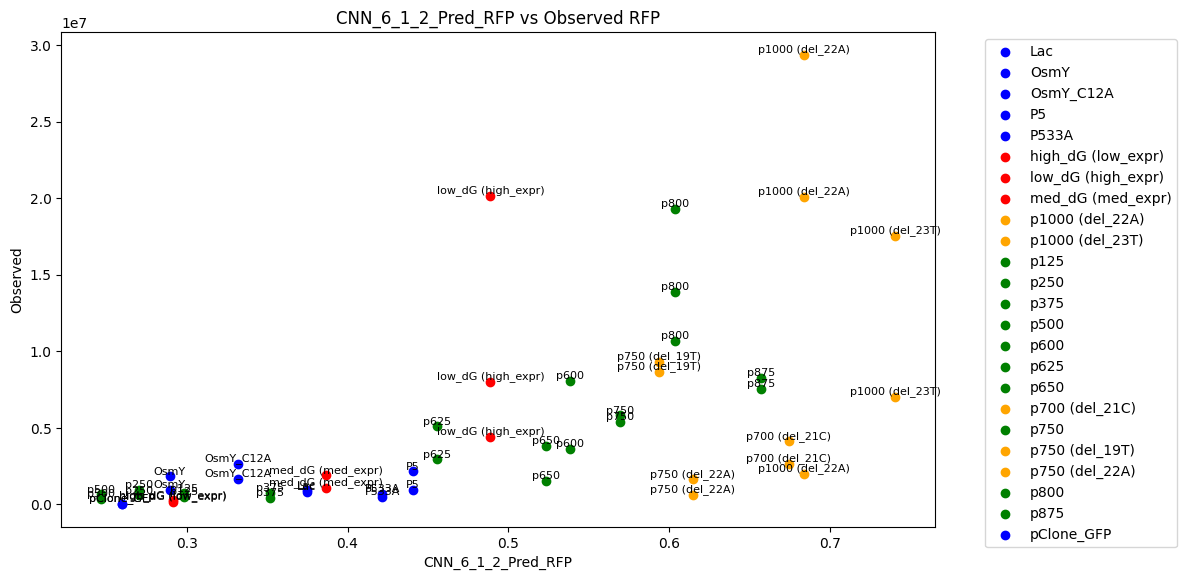

In [11]:
for predictions in ['CNN_5_0_Pred_RFP', 'CNN_5_1_Pred_RFP', 'CNN_5_6_Pred_RFP', 'CNN_6_1_2_Pred_RFP']:
    plt.figure(figsize=(12, 6))

    for promoter in unique_promoters:
        subset = df[df['Strain'] == promoter]
        color = color_map[promoter]
        plt.scatter(subset[predictions], subset['Rel_RFP'], c=[color], label=promoter)

    plt.xlabel(predictions)
    plt.ylabel('Observed')
    plt.title(f'{predictions} vs Observed RFP')

    for row in df.iterrows():
        plt.text(row[1][predictions], row[1]['Rel_RFP'], row[1]['Strain'], fontsize=8, ha='center', va='bottom')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()